In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pymc as pm
# import pymc_bart as pmb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.inspection import permutation_importance

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [18]:
data = pd.read_csv('Full_Descriptors.csv')
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [4]:
param_grid = {
    "n_estimators": [0,10,50,100],
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = ExtraTreesRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy versio

Param for GS {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
CV score for GS 0.8658926563677813
Train AUC ROC Score for GS:  0.9994448703375717
Test AUC ROC Score for GS:  0.8286878216123499


Text(0.5, 1.0, 'LUMO')

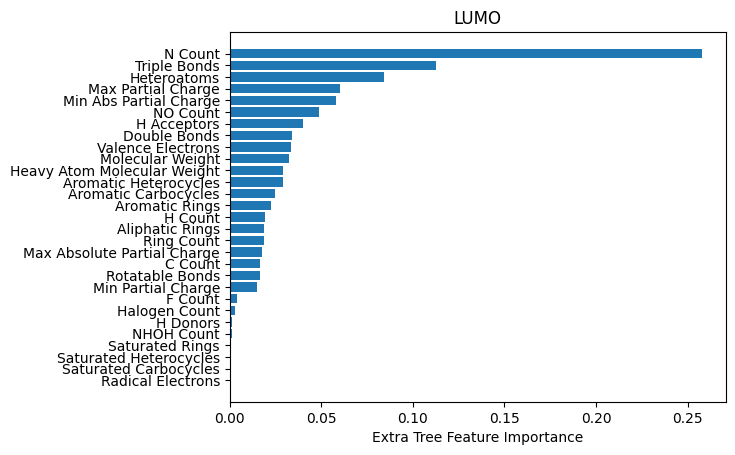

In [19]:
model = ExtraTreesRegressor(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X_train, y_train)

sorted_idx = model.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Extra Tree Feature Importance")
plt.title("LUMO")

In [6]:
r = permutation_importance(model, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

N Count 0.454 +/- 0.045
Triple Bonds0.173 +/- 0.016
Heteroatoms0.044 +/- 0.006
Min Abs Partial Charge0.038 +/- 0.004
Max Partial Charge0.038 +/- 0.003
NO Count0.031 +/- 0.003
Double Bonds0.031 +/- 0.003
Aromatic Carbocycles0.017 +/- 0.002
H Acceptors0.014 +/- 0.003
Aliphatic Rings0.012 +/- 0.002
Aromatic Heterocycles0.009 +/- 0.001
H Count 0.009 +/- 0.001
Valence Electrons0.007 +/- 0.001
Min Partial Charge0.007 +/- 0.001
Max Absolute Partial Charge0.007 +/- 0.001
Heavy Atom Molecular Weight0.007 +/- 0.001
Molecular Weight0.006 +/- 0.001
Rotatable Bonds0.005 +/- 0.001
Aromatic Rings0.004 +/- 0.000
Ring Count0.004 +/- 0.001
C Count 0.003 +/- 0.000
F Count 0.002 +/- 0.000
Halogen Count0.001 +/- 0.000
H Donors0.001 +/- 0.000
NHOH Count0.000 +/- 0.000
Saturated Heterocycles0.000 +/- 0.000
Saturated Rings0.000 +/- 0.000


In [7]:
model.fit(X_train, y_train)

r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

N Count 0.560 +/- 0.136
Triple Bonds0.170 +/- 0.044
Double Bonds0.089 +/- 0.025
Max Partial Charge0.060 +/- 0.023
Min Partial Charge0.021 +/- 0.009
Max Absolute Partial Charge0.018 +/- 0.008
NHOH Count0.006 +/- 0.001
H Donors0.005 +/- 0.002


In [8]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.0 degrees.


In [9]:
from sklearn.metrics import mean_squared_error

prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = model.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

R2:  0.4928931992698883
MSE:  4.932803785714295e-05
RMSE:  0.00702339219018438


In [11]:
data = pd.read_csv('Full_Descriptors.csv')
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

param_grid = {
    "n_estimators": [0,10,50,100],
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = ExtraTreesRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2160 fits failed out of a total of 8640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2160 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/pyth

Param for GS {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
CV score for GS 0.7826560337564087
Train AUC ROC Score for GS:  0.9901858117179528
Test AUC ROC Score for GS:  0.811853448275862


Text(0.5, 1.0, 'HOMO')

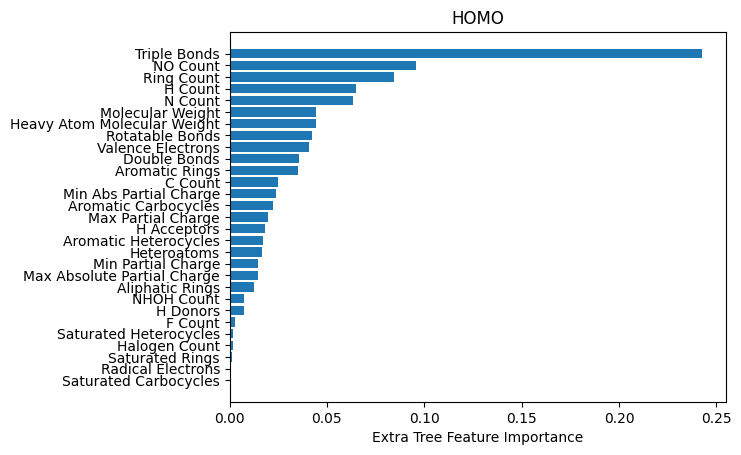

In [17]:
model = ExtraTreesRegressor(random_state=42, max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model.fit(X_train, y_train)

sorted_idx = model.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Extra Tree Feature Importance")
plt.title("HOMO")

In [14]:
r = permutation_importance(model, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f" {r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Triple Bonds0.415 +/- 0.049
H Count 0.069 +/- 0.007
NO Count0.065 +/- 0.005
Ring Count0.044 +/- 0.004
N Count 0.043 +/- 0.005
Rotatable Bonds0.031 +/- 0.003
Double Bonds0.031 +/- 0.002
Molecular Weight0.028 +/- 0.003
Aromatic Carbocycles0.021 +/- 0.002
Heavy Atom Molecular Weight0.021 +/- 0.001
Valence Electrons0.016 +/- 0.001
Aromatic Rings0.014 +/- 0.001
Max Partial Charge0.014 +/- 0.001
Aliphatic Rings0.009 +/- 0.001
Min Abs Partial Charge0.008 +/- 0.001
C Count 0.008 +/- 0.001
Aromatic Heterocycles0.008 +/- 0.001
Min Partial Charge0.007 +/- 0.001
H Acceptors0.007 +/- 0.001
Max Absolute Partial Charge0.006 +/- 0.001
Heteroatoms0.004 +/- 0.000
NHOH Count0.003 +/- 0.000
H Donors0.002 +/- 0.000
F Count 0.001 +/- 0.000
Halogen Count0.001 +/- 0.000
Saturated Heterocycles0.000 +/- 0.000
Saturated Rings0.000 +/- 0.000


In [15]:
model.fit(X_train, y_train)

r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f" {r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Triple Bonds0.246 +/- 0.043
H Count 0.094 +/- 0.020
NO Count0.085 +/- 0.021
Rotatable Bonds0.040 +/- 0.009
Molecular Weight0.021 +/- 0.010
C Count 0.019 +/- 0.004
Valence Electrons0.013 +/- 0.005


In [16]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

from sklearn.metrics import mean_squared_error

prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = model.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

Mean Absolute Error: 0.0 degrees.
R2:  0.6747213998093822
MSE:  2.9061651425397855e-05
RMSE:  0.005390885959227653
